# Investigating device properties with GEM experiment


### 1. Overview
GEM (Generation of Entanglement by Measurement) is a measurement-based technique to prepare device-wide entangling states with constand-depth circuits, which is introduced by [the paper from Edward H. Chen et. al](https://arxiv.org/abs/2309.02863). Our library provides its [Qiskit Experiments](https://github.com/Qiskit-Extensions/qiskit-experiments) implementation for conventional IBM Quantum processors with the heavy hexagonal lattice topology, with 2D preparation protocol which is know to be highly noise-resistant. 

In [1]:
from gem_suite import PlaquetteLattice
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

### 2. Plaquette Concept

Key to understanding the GEM protocol is the concept of a basic, repeatable, experimental unit called a "plaquette." This object is tiled across the quantum processor, and is composed of a single heavy-hexagonal lattice. The single experimental unit forms a collection of 12 qubits. Because of this, a 127 qubit Eagle device can be represented by 18 plaquettes. Their connectivity can be also visualized by a graph like qubits, where the plaquette graph edge shares 3 qubits, and 2 qubits are not included in any plaquette in this device design.

In [2]:
plaquettes = PlaquetteLattice.from_backend(FakeSherbrooke())

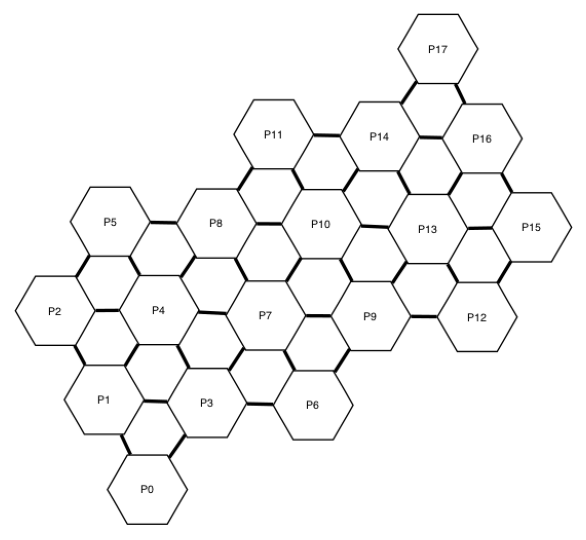

In [3]:
plaquettes.draw_plaquettes()

We can get component qubits in each plaquette by calling the `.plaquettes` method.

In [4]:
next(plaquettes.plaquettes())

PyPlaquette(index=0, qubits=[0, 1, 2, 3, 4, 14, 15, 18, 19, 20, 21, 22], neighbors=[3, 1])

### High Level Overview of the GEM Protocol

Shown below in this graph view with convenient annotations, qubits can be classified as either site or bond qubits. The filled circuits are site qubits while the open circuits are bond qubits. To turn an initial product state of site qubits in +1 X eigenstates into a GHZ-type state, we measure the ZZ parities on all nearest neighbor site qubits using the bond qubits in between. We sweep the control rotation angle to "A" sublattice (site qubits with annotation "A"). This induces a coupling to bond qubits beyond a simple Clifford CNOT gate. By varying this angle away from the Clifford limit we can successfully perform tunable weak measurement.

Three layers of entangling operations are always needed in the heavy hexagonal lattice due to the degree-3 connectivity. Edges in the graph are also grouped by different colors. Graph edges are scheduled so that no adjacent edges appear in the same layer, avioding collisions. In this configuration, we can generate 12 different scheduling patterns which may yield different noise levels due to different contributions of gate crosstalk.

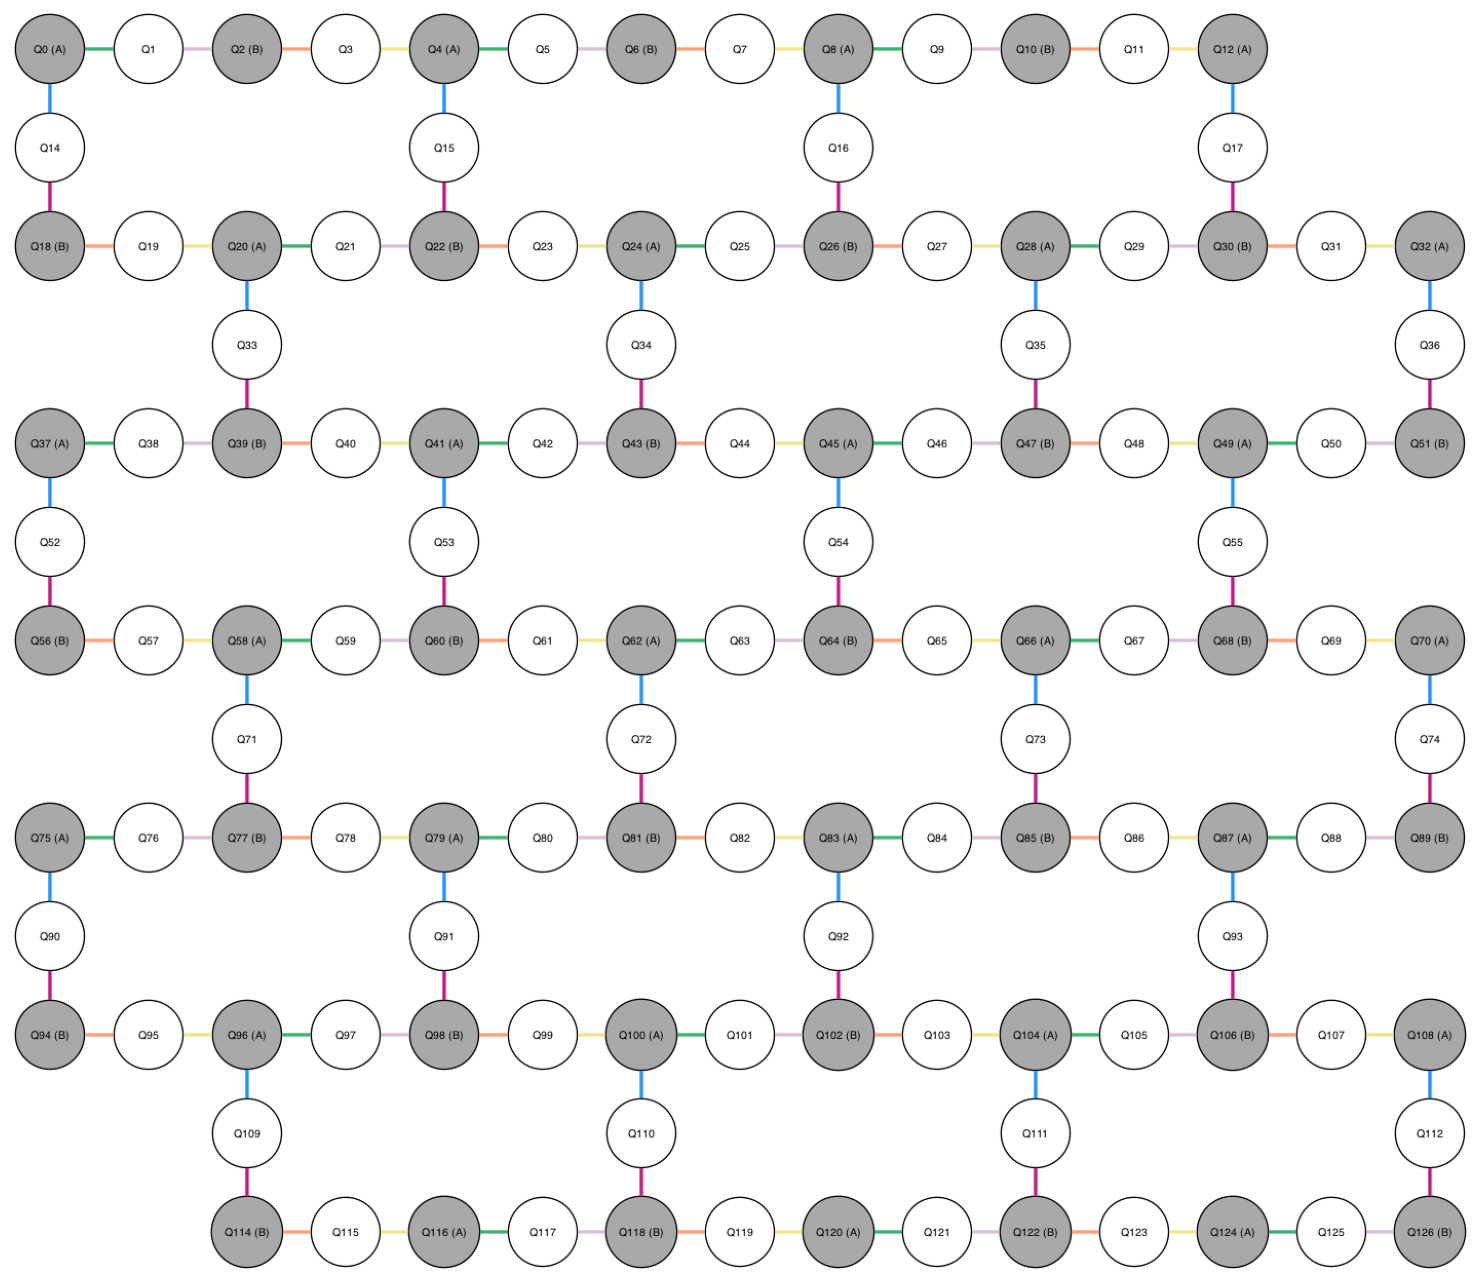

In [5]:
plaquettes.draw_qubits()

The `PlaquetteLattice` offers a method to generate the gate schedules by consuming above annotated qubit graph. You can prepare GEM circuits with this information.

In [6]:
for i, group in enumerate(plaquettes.build_gate_schedule(10)):
    print(f"group #{i}")
    for j, edge in enumerate(group):
        if j > 5:
            print("...")
            break
        print(edge)

group #0
PyGate(index0=3, index1=4, group="A")
PyGate(index0=7, index1=8, group="A")
PyGate(index0=11, index1=12, group="A")
PyGate(index0=19, index1=20, group="A")
PyGate(index0=23, index1=24, group="A")
PyGate(index0=27, index1=28, group="A")
...
group #1
PyGate(index0=0, index1=1, group="A")
PyGate(index0=4, index1=5, group="A")
PyGate(index0=8, index1=9, group="A")
PyGate(index0=20, index1=21, group="A")
PyGate(index0=24, index1=25, group="A")
PyGate(index0=28, index1=29, group="A")
...
group #2
PyGate(index0=0, index1=14, group="A")
PyGate(index0=4, index1=15, group="A")
PyGate(index0=8, index1=16, group="A")
PyGate(index0=12, index1=17, group="A")
PyGate(index0=20, index1=33, group="A")
PyGate(index0=24, index1=34, group="A")
...


You can also build a sublattice from your plaquette lattice, if you have a particular subset of interest to run experiment.

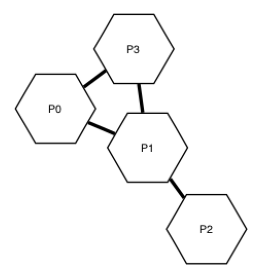

In [7]:
sub_plaquettes = plaquettes.filter([0, 1, 2, 3])
sub_plaquettes.draw_plaquettes()

### 2. Running through Qiskit Experiments

Now let's move on to integaration into Qiskit Experiments. Although in principle you can build and run the GEM experiment manually, it's convenient to run it through Qiskit Experiments class.

In [8]:
from gem_suite.experiments import GemExperiment
from qiskit_ibm_runtime.fake_provider import FakeGeneva

In [9]:
gem_exp = GemExperiment([0, 1], backend=FakeGeneva())

The experiment class can be instantiated either with numerical indices of plaquettes or a `PlaquetteLattice` instance. In this example, we use FakeGeneva backend with 27 qubits so that the experiment can run on the Qiskit Aer simulator. You must install `pip install qiskit-aer` to continue.

In [10]:
gem_exp.experiment_options

Options(max_circuits=None, schedule_idx=None, sweep_type='A', min_angle=0, max_angle=1.5707963267948966, num_angles=21, angles=None)

In [11]:
gem_exp.set_experiment_options(schedule_idx=10)

We only simulate a single scheduling pattern since this simulation is expensive. In default setting, the GEM experiment runs 21 experiment circuits with different control rotation angles from [0, pi/2], where pi/2 is at the Clifford limit. Without specifying the `scheduling_idx`, the experiment tries all 12 scheduling patterns and computes the result as an average of these patterns. In total, 252 circuits will run in a single execution. Here we run only scheduling index 10.

With a real backend, we can simply run the following code to get the results.

In [12]:
# exp_data = gem_exp.run().block_for_results()

In case of the density matrix simulator, noisy ISA circuits with 27 qubits are hardly able to be executed on a standard laptop computer. Instead, we cleverly bypass transpilation and consideration of ancilla qubits in the full layout. We will see the complete workflow with a real utility scale computer later.

Without transpiling, the GEM circuits have only 21 qubits. This circuit can be simulated on a laptop. Here we directly run a virtual (non-transpiled) circuit on the Aer simulator with a noise model. In contrast to RB-variant protocols such as the [layer fidelity experiment](https://arxiv.org/abs/2311.05933) the GEM protocol is sensitive to the measurement error by design. We can recover the noiseless state with the Minimum Weight Perfect Matching (MWPM) decoder. At a critical control angle, this recovery starts to fail. It is at this failure point that the Nishimori transition occurs.

In this simulation, we only consider the impact of measurement errors.

In [13]:
from qiskit_experiments.framework import ExperimentData
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError

import numpy as np

In [14]:
rng = np.random.default_rng(1234)

noise_model = NoiseModel()
for vi, _ in enumerate(gem_exp.physical_qubits):
    err = rng.uniform(0.0, 0.05)
    noise_model.add_readout_error(ReadoutError([[1.0 - err, err], [err, 1.0 - err]]), [vi])
sim_backend = AerSimulator(noise_model=noise_model, seed_simulator=5678)

In [15]:
job = sim_backend.run(gem_exp.circuits(), shots=10000)

In [16]:
exp_data = ExperimentData(experiment=gem_exp, backend=sim_backend)
exp_data.add_jobs(job)
exp_data.block_for_results()

ExperimentData(GemExperiment, da6831ae-a8e6-493b-ab80-33256e18400b, job_ids=['d096cc06-49da-441f-9539-dc085ee8a326'], metadata=<5 items>)

In [17]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 337 ms, sys: 20.4 ms, total: 357 ms
Wall time: 350 ms


After the experiment completes, we can get four quantities in the analysis results dataframe. Each parameter characterizes the capability of entanglement preparation of this quantum processor from different aspect.

#### max_tpc
An average of the maximum two-point (classical) correlation between two arbitrary site qubits. The higher the value, the better the entanglement generation capability (range [0.0, 1.0]).

#### critical_angle
A control rotation angle where the Nishimori transition occurs. 0.5 is the Clifford limit and thus the maximum value of the quantity. The smaller the value, the better the noise tolerance (range [0.0, 0.5]).

#### p_bond_mean
A parameter characterizing the average measurement error in bond qubits and noise during the entangling process.

#### p_site_mean
A parameter characterizing the average measurement error in site qubits.

In [18]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic
ac555db6,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None
619471e7,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None
26c8c9e8,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862
0da80d81,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862


In addition to above numbers, you will find four figures associated with the result.

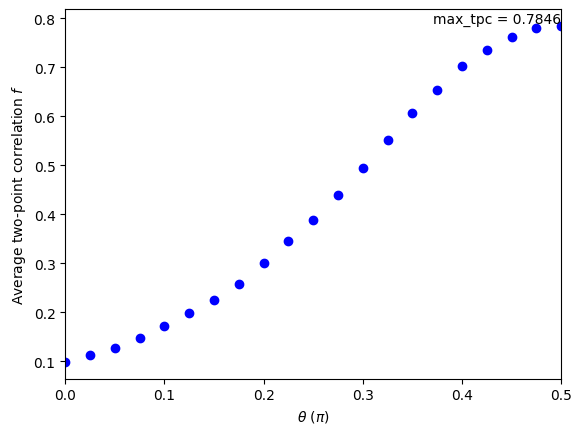

In [19]:
analyzed_data.figure(0)

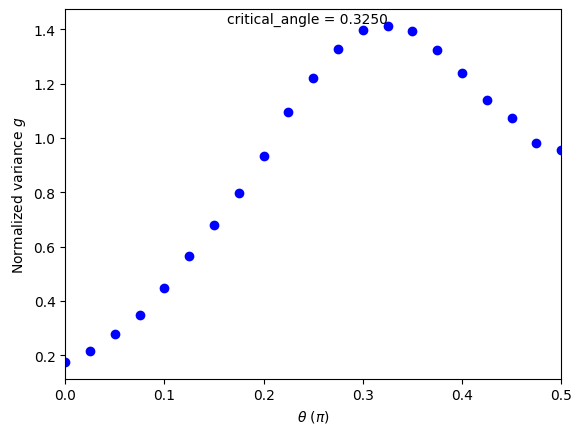

In [20]:
analyzed_data.figure(1)

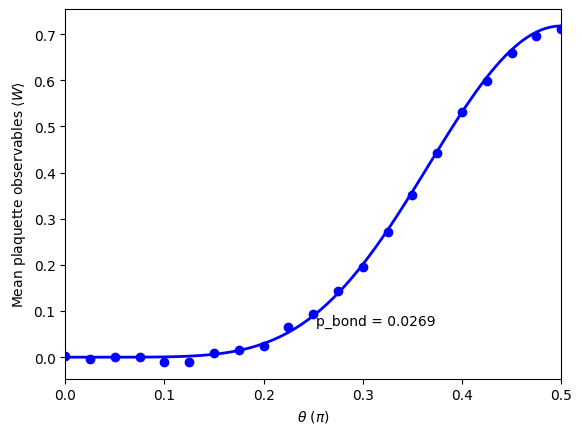

In [21]:
analyzed_data.figure(2)

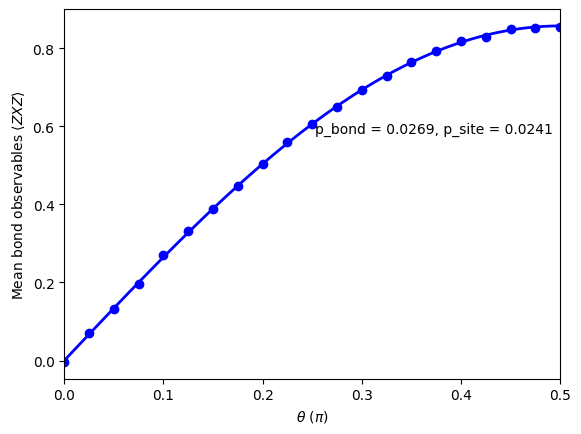

In [22]:
analyzed_data.figure(3)

### 3. Customizing measurement options
You can also customize analysis options.

In [23]:
gem_exp.analysis.options

Options(figure_names=None, analyze_individual_bond=False, analyze_clifford_limit=False, decoder='pymatching')

First, our library implements two MWPM decoders, namely [pymatching](https://github.com/oscarhiggott/PyMatching) and [fusion-blossom](https://github.com/yuewuo/fusion-blossom). The quality of the result doesn't significantly depend on the choice of decoder and they are tested against the same mock configuration to confirm the results are comparable. Unfortunately the latter is slower (although its implemented in Rust and in principle there is no FFI overhead with our library, which is also written in Rust). Thus, our setting defaults to the pymatching decoder.

Note that in the default configuration we only see the wholistic metrics of the entire processor. We can also produce local properties in different levels. With small addition of computing resources, you can obtain a quality metric for each plaquette.

In [24]:
gem_exp.analysis.set_options(analyze_clifford_limit=True, analyze_individual_bond=False, decoder="pymatching")

In [25]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 394 ms, sys: 56.2 ms, total: 450 ms
Wall time: 727 ms


In [26]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic,plaquette
b28fb584,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None,None
cd04dc0d,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None,None
787aa9b4,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862,None
d3e0b553,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862,None
6d467556,plaquette_quality,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.8405959051832326+/-0,None,aer_simulator,None,None,None,0
8404006e,plaquette_quality,GemExperiment,"[Q12, Q13, Q14, Q15, Q16, Q18, Q19, Q21, Q22, ...",0.8246114147824619+/-0,None,aer_simulator,None,None,None,1


The quality metric is computed as a geometric means of $\langle W \rangle$ observable and all $\langle ZXZ \rangle$ observables in the plaquette at the Clifford limit, where the $\langle W \rangle = \langle ZZZZZZ \rangle$ is the plaquette observable of six site qubits in the plaquette, and $\langle ZXZ \rangle$ is a bond correlations in the plaquette. You must include pi/2 in your experiment parameter to obtain these numbers. Without noise, this metric becomes 1.0 and it is somewhat related to the regional quality of your quantum processor. This may help you with extracting the best part of your processor to run circuits with a common pandas dataframe operation like below.

In [27]:
best_plaquette = res[res.name == "plaquette_quality"].sort_values("value", ascending=False).iloc[0]
best_qubits = [q.index for q in best_plaquette.components]
best_qubits

[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14]

This option will produce an extra figure to visualize the distribution of metric across different plaquettes regions. The brightness of the filled plaquettes is proportional to the value of the metric.

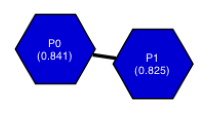

In [28]:
analyzed_data.figure(4)

In principle, we can compute p_bond and p_site parameters for each bond. This will produce more localized view of the device quality.

In [29]:
gem_exp.analysis.set_options(analyze_clifford_limit=False, analyze_individual_bond=True, decoder="pymatching")

In [30]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 753 ms, sys: 136 ms, total: 889 ms
Wall time: 574 ms


In [31]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic
235c449d,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None
ce0787fa,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None
f07f668f,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862
97de3412,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862
b99ed249,p_bond,GemExperiment,"[Q2, Q3, Q1]",0.5+/-nan,Good,aer_simulator,None,0.0,None
3e38516e,p_site,GemExperiment,"[Q2, Q3, Q1]",0.45588349978499815+/-nan,Good,aer_simulator,None,0.0,None
f2f4cc95,p_bond,GemExperiment,"[Q4, Q7, Q1]",0.5+/-nan,Good,aer_simulator,None,0.0,None
9b323e64,p_site,GemExperiment,"[Q4, Q7, Q1]",0.44563060056604287+/-nan,Good,aer_simulator,None,0.0,None
046aba1d,p_bond,GemExperiment,"[Q5, Q8, Q3]",0.5+/-nan,Good,aer_simulator,None,0.0,None
8f7adc26,p_site,GemExperiment,"[Q5, Q8, Q3]",0.44705361252827314+/-nan,Good,aer_simulator,None,0.0,None


### 4. Utility-scale experiement with real quantum processor

Lastly we demonstrate how to run the GEM experiment on a real quantum processor from IBM Quantum. The workflow is much simpler because there is no resource limit in the classical computation to run the experiment. We just run it and wait for the result. In this example we test all 12 scheduling patterns to see the dependency on the gate crosstalk. The more divergent the traces (i.e. gray lines behind blue scatters), the greater the contribution of the gate crosstalk.

With one of the Eagle processors like ibm_osaka, we can run the GEM experiment using 18 plaquettes.

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [33]:
backend = QiskitRuntimeService().backend("ibm_osaka")

In [35]:
gem_exp = GemExperiment(range(18), backend=backend)
gem_exp.analysis.set_options(analyze_clifford_limit=True, analyze_individual_bond=False, decoder="pymatching")

analyzed_data = gem_exp.analysis.run(exp_data).block_for_results();
exp_data = gem_exp.run(analysis=None).block_for_results()

ExperimentData(GemExperiment, 03e639c0-3712-4be6-8842-891028cb84fa, job_ids=['cv6nne539kwg008vwwg0'], metadata=<5 items>)

In [36]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 10.8 s, sys: 228 ms, total: 11 s
Wall time: 11.4 s


In [37]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic,plaquette
0c288179,max_tpc,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.04218+/-0.00026,None,ibm_osaka,None,None,None,None
c39bef25,critical_angle,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.475,None,ibm_osaka,None,None,None,None
de26bd67,p_bond_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.273+/-0.011,Good,ibm_osaka,None,1.666213,12.619865,None
39fdc9e3,p_site_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.156+/-0.016,Good,ibm_osaka,None,1.666213,12.619865,None
2dabed66,plaquette_quality,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q14, Q15, Q18, Q19, Q20, ...",None,None,ibm_osaka,None,None,None,0
f1dff948,plaquette_quality,GemExperiment,"[Q4, Q5, Q6, Q7, Q8, Q15, Q16, Q22, Q23, Q24, ...",None,None,ibm_osaka,None,None,None,1
e08e0e9a,plaquette_quality,GemExperiment,"[Q8, Q9, Q10, Q11, Q12, Q16, Q17, Q26, Q27, Q2...",None,None,ibm_osaka,None,None,None,2
cb8b8f19,plaquette_quality,GemExperiment,"[Q20, Q21, Q22, Q23, Q24, Q33, Q34, Q39, Q40, ...",None,None,ibm_osaka,None,None,None,3
8fa63ec5,plaquette_quality,GemExperiment,"[Q24, Q25, Q26, Q27, Q28, Q34, Q35, Q43, Q44, ...",0.222+/-0.021,None,ibm_osaka,None,None,None,4
a983e97c,plaquette_quality,GemExperiment,"[Q28, Q29, Q30, Q31, Q32, Q35, Q36, Q47, Q48, ...",0.327+/-0.024,None,ibm_osaka,None,None,None,5


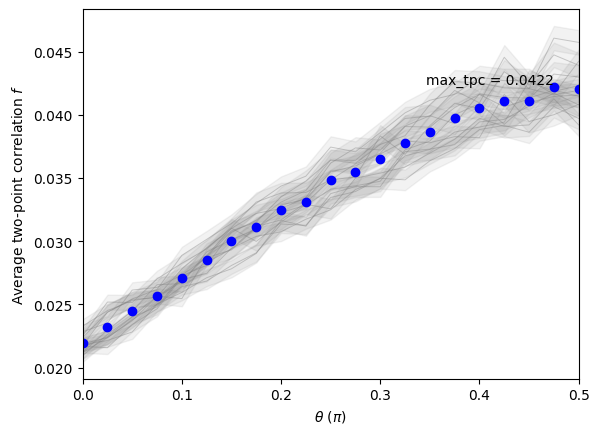

In [38]:
analyzed_data.figure(0)

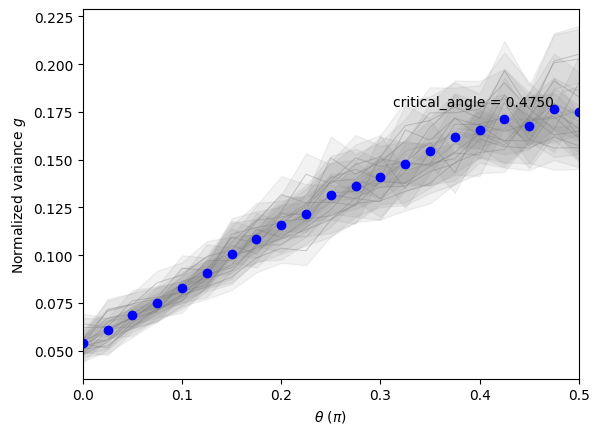

In [39]:
analyzed_data.figure(1)

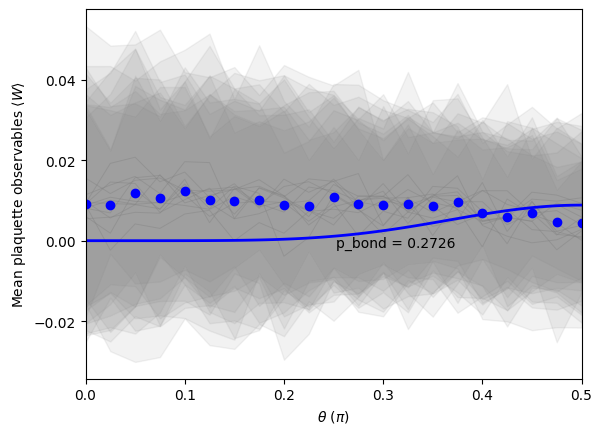

In [40]:
analyzed_data.figure(2)

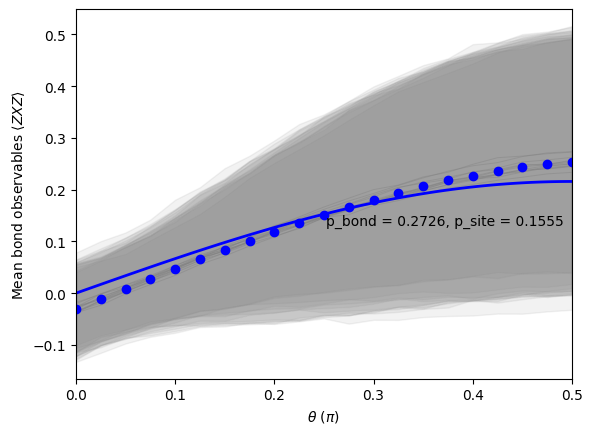

In [41]:
analyzed_data.figure(3)

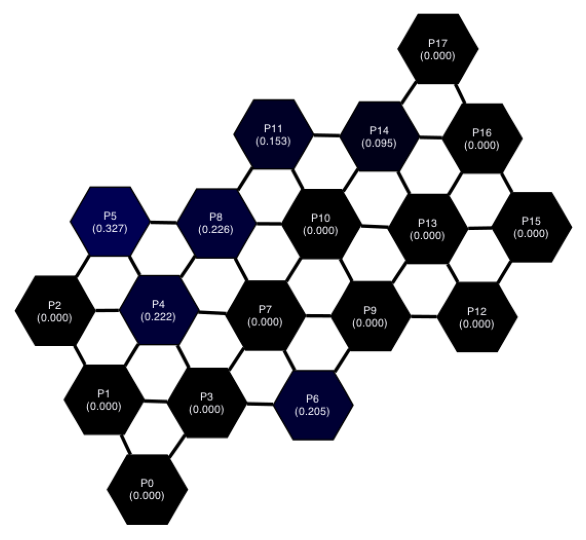

In [42]:
analyzed_data.figure(4)

As you can see, $\langle W \rangle$ or $\langle ZXZ \rangle$ observables show negative value in several plaquettes, even in the Clifford limit. This indicates that the decoder output doesn't produce the long range order owing to non-negligible imperfection in the real quantum hardware. This is also explained by the small `max_tpc` metric conpared with the previous simulation. However, there still be well-behaving region aound the plaquette 5. Since these metrics strongly depend on the measurement noise, you may see a trend different from the EPLGs (error per layered gates) and conventional EPGs (error per gates).